In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scienceplots as scp

import numpy as np
import torch

matplotlib.rcParams['figure.figsize'] = (20, 6)

from main import main, parse_args

from argparse import Namespace
from utils.plotting import plot_change_responses, plot_trial_responses, plot_omission_responses, plot_sequence_response
from utils.analysis import process_outputs, get_change_responses, get_omission_responses

import os

import warnings
warnings.filterwarnings('ignore')

SCRATCH = "/storage/scratch1/2/asharafeldin3"

In [2]:
import importlib 
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_change_responses, plot_trial_responses, plot_omission_responses, plot_sequence_response

In [3]:
def load_results_files(directory, prefix):
    # Ensure directory exists
    if not os.path.isdir(directory):
        print(f"Error: {directory} is not a valid directory.")
        return {}

    # Get list of files in directory
    files = os.listdir(directory)
    # Filter files by prefix and ending with '.pt'
    torch_files = [file for file in files if file.startswith(prefix)]

    args = None

    change_responses = {"familiar": {}, "novel": {}}
    omission_responses = {"familiar": {}, "novel": {}}
    training_progress = {}
    for i, file in enumerate(torch_files):
        file_path = os.path.join(directory, file)
        try:
            # Load Torch file
            data = torch.load(file_path, map_location='cpu')
            # Concatenate tensors along the first axis

            if args is None:
                args = data['args']

            # first for change responses
            for key in data["change_responses"]["familiar"].keys():
                fam_value = data["change_responses"]["familiar"][key]
                nov_value = data["change_responses"]["novel"][key]
                if key not in change_responses["familiar"]:
                    change_responses["familiar"][key] = fam_value
                    change_responses["novel"][key] = nov_value
                else:
                    change_responses["familiar"][key] = torch.cat([change_responses["familiar"][key], fam_value])
                    change_responses["novel"][key] = torch.cat([change_responses["novel"][key], nov_value])
            
            # now for omission responses
            for key in data["omission_responses"]["familiar"].keys():
                fam_value = data["omission_responses"]["familiar"][key]
                nov_value = data["omission_responses"]["novel"][key]
                if key not in omission_responses["familiar"]:
                    omission_responses["familiar"][key] = fam_value
                    omission_responses["novel"][key] = nov_value
                else:
                    omission_responses["familiar"][key] = torch.cat([omission_responses["familiar"][key], fam_value])
                    omission_responses["novel"][key] = torch.cat([omission_responses["novel"][key], nov_value])
            
            # finally training progress
            for key in data['training_progress'].keys():
                if key not in training_progress:
                    training_progress[key] = [data['training_progress'][key]]
                else:
                    training_progress[key] += [data['training_progress'][key]]

            print(f"Loaded {i + 1}/{len(torch_files)} files", end='\r')
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
    
    training_progress = {k: np.stack(v) for k, v in training_progress.items()}
    
    return args, change_responses, omission_responses, training_progress

### Perception only

In [ ]:
passive_args, passive_change, passive_omission, passive_progress = load_results_files(f"{SCRATCH}/novelty_encoding_model/results/perception_only/w", "perception_only")
passive_args = Namespace(**passive_args)

In [ ]:
##### plot responses around image change

with plt.style.context(['nature', 'notebook']):
        
    passive_change_fig = plt.figure(figsize=(20, 15))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(passive_change['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_trial_responses(passive_args, ax, passive_change['familiar'][pop], passive_change['novel'][pop], normalize=False)
        ax.set_title(f"{pop}")
        ax.legend()

In [ ]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):
    
    passive_omission_fig = plt.figure(figsize=(20, 15))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(passive_omission['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_trial_responses(passive_args, ax, passive_omission['familiar'][pop], passive_omission['novel'][pop], trial_mode='omission', normalize=False)
        _ = ax.set_title(f"{pop}")

### Perception with Action

In [19]:
active_args, active_change, active_omission, active_progress = load_results_files(f"{SCRATCH}/novelty_encoding_model/results/perception_action", "perception_action")
active_args = Namespace(**active_args)

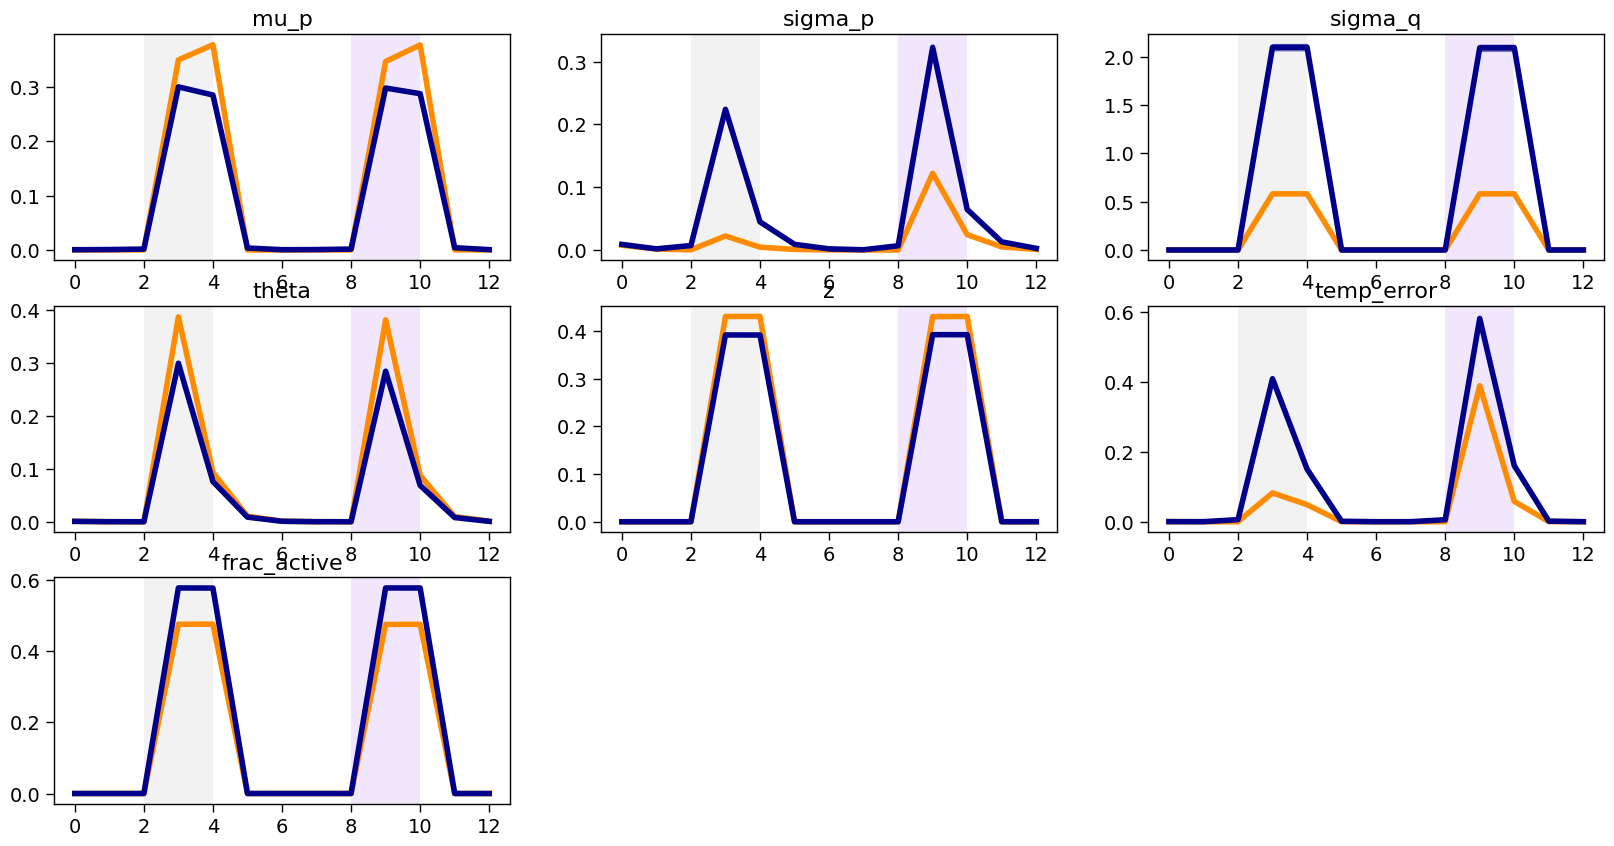

In [20]:
##### plot responses around image change

with plt.style.context(['nature', 'notebook']):
        
    active_change_fig = plt.figure(figsize=(20, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(active_change['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_trial_responses(active_args, ax, active_change['familiar'][pop], active_change['novel'][pop], normalize=False)
        ax.set_title(f"{pop}")
        #ax.legend()

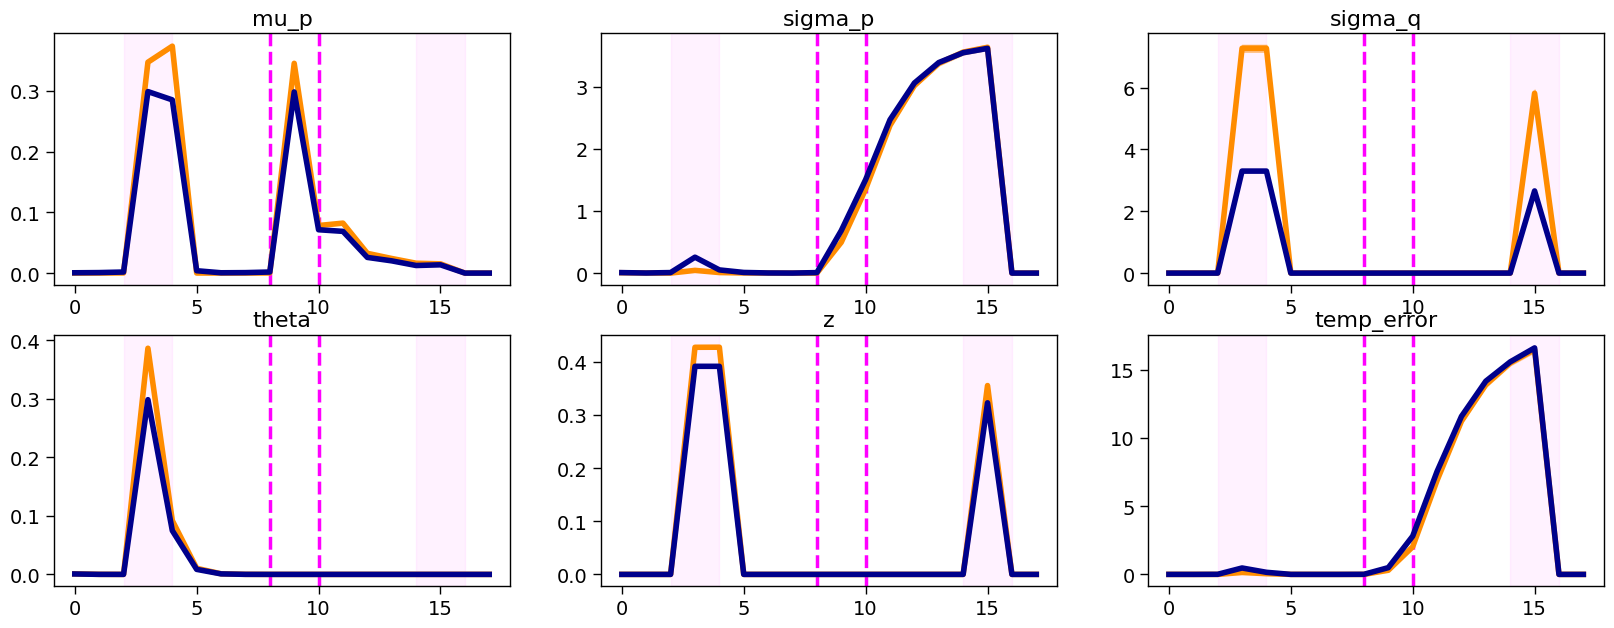

In [21]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):

    active_omission_fig = plt.figure(figsize=(20, 15))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(active_omission['familiar'].keys()):
        ax = plt.subplot(4, 3, i+1)
        plot_trial_responses(active_args, ax, active_omission['familiar'][pop], active_omission['novel'][pop], trial_mode='omission', normalize=False)
        _ = ax.set_title(f"{pop}")

### Raincloud plots

torch.Size([64])


Text(0.5, 1.0, 'VIP (sigma_p)')

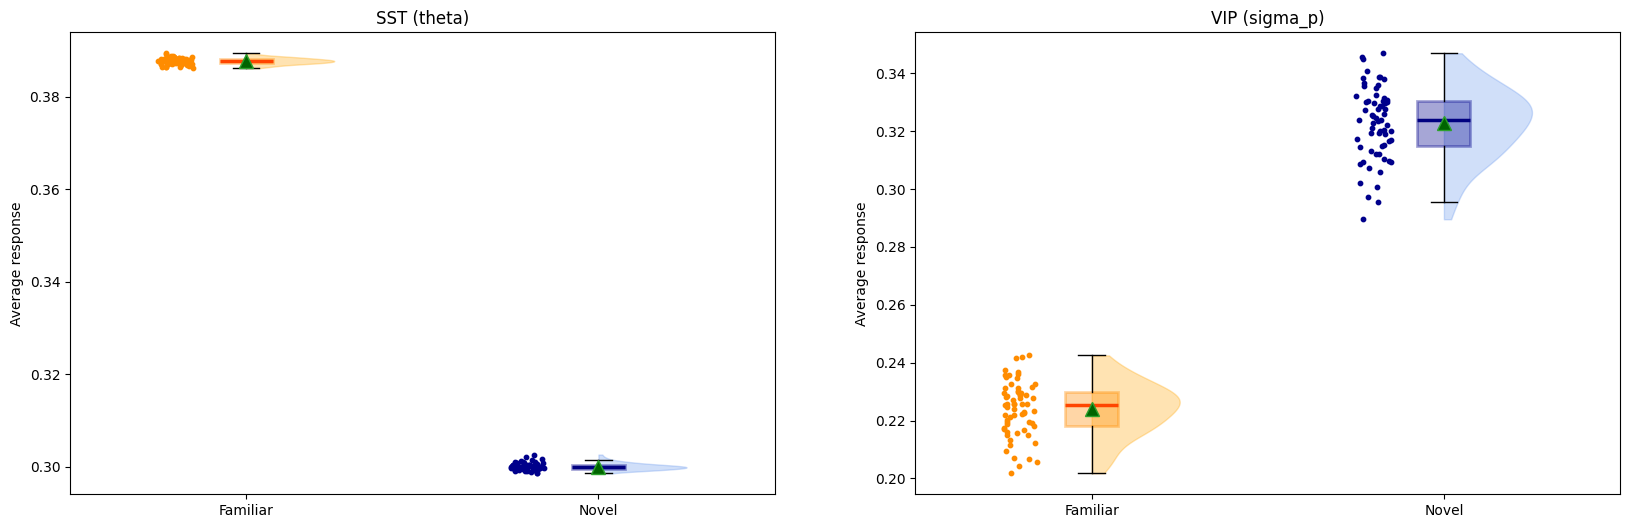

In [22]:
from utils.plotting import raincloud_plot

sq = 3

exp_ax1 = plt.subplot(1, 2, 1)
famt = active_change['familiar']['theta'][:, 3].detach()
novt = active_change['novel']['theta'][:, 3].detach()
nonlin = lambda x: x.mean(0) #torch.relu(x - .95).mean(0) #(1 - 0.1 * x).mean(-1) 
print(nonlin(novt).shape)
raincloud_plot(exp_ax1, nonlin(famt), nonlin(novt))
plt.title('SST (theta)')
#plt.ylim([0., 0.65])

exp_ax2 = plt.subplot(1, 2, 2)
fams = active_change['novel']['sigma_p'][:, 3].detach()
novs = active_change['novel']['sigma_p'][:, 9].detach()
raincloud_plot(exp_ax2, torch.mean(fams, dim=0), torch.mean(novs, dim=0))
plt.title('VIP (sigma_p)')
#plt.ylim([0., 0.1])

### Training progress

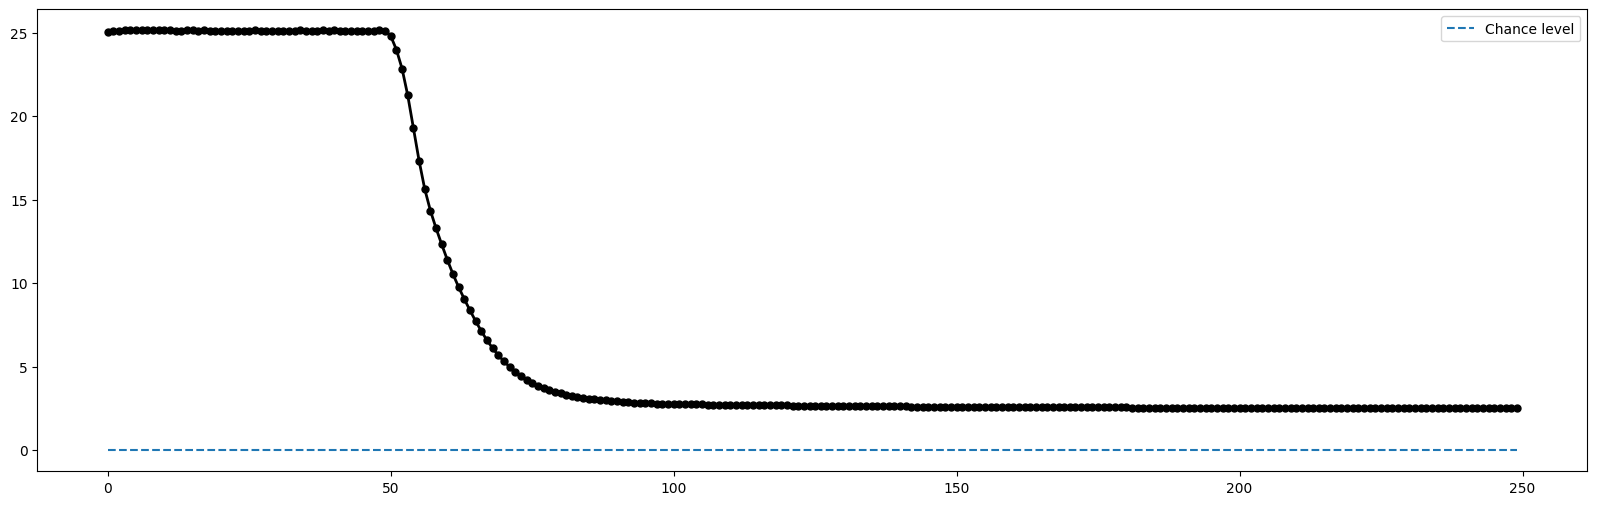

In [23]:
dprime = active_progress['temporal_error'].mean(0)
plt.plot(dprime, '-ok', linewidth=2.0, markersize=5)
plt.plot(np.arange(len(dprime)), np.zeros_like(dprime), '--', label='Chance level')
plt.legend()